# Option B - Visualization: Can you build a visualization (interactive or static) of the trip data that helps us understand intra- vs. inter-borough traffic? What story does it tell about how New Yorkers use their green taxis?

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import requests
import io
import zipfile
import glob
from bs4 import BeautifulSoup

from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
from tabulate import tabulate


from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import geopandas as gpd
import matplotlib
from shapely.geometry import Point, Polygon

import rtree

%matplotlib inline 

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Downloading necessary dataset. NYC Green Taxi data and NYC Neighborhood Tabulation data and converting it into geopandas dataframe

In [2]:
link = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
s = requests.get(link).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979,40.685,-73.979,40.685,1,...,7.800,0.000,0.000,1.950,0.000,nan,0.000,9.750,1,2.000
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.011,40.912,-74.011,40.912,1,...,45.000,0.000,0.000,0.000,0.000,nan,0.000,45.000,1,2.000
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921,40.767,-73.914,40.765,1,...,4.000,0.500,0.500,0.500,0.000,nan,0.300,5.800,1,1.000
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921,40.767,-73.931,40.772,1,...,5.000,0.500,0.500,0.000,0.000,nan,0.300,6.300,2,1.000
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955,40.714,-73.944,40.715,1,...,5.000,0.500,0.500,0.000,0.000,nan,0.300,6.300,2,1.000


# The shapefile for Neighborhood Tabulation Data has been downloaded from NYC Open Data website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq

In [5]:
nyc_neighborhood_df = gpd.read_file('/Users/mayankajha/Downloads/Neighborhood_Tabulation_Areas/geo_export_0280bbd8-50c7-420e-a2c0-5150a42f0c31.shp')

In [6]:
#converting shapefile into geopandas dataframe
crs = {'init': 'epsg:4326'}
geo_df_nyc_neighborhood = gpd.GeoDataFrame(nyc_neighborhood_df, crs=crs, geometry = nyc_neighborhood_df.geometry)

In [7]:
geo_df_nyc_neighborhood.shape

(195, 8)

# Now using the shapefile, I will extract the pickup borough and neighborhood as well as drop-off borough and neighborhood information

In [6]:
#duplicating a new dataframe for extracting pickup information
df_pickup = df
df["new_index"] = range(0, len(df))

In [7]:
#calculating geometry and assigning crs val, to create geopandas dataframe
geometry = [Point(xy) for xy in zip(df_pickup['Pickup_longitude'], df_pickup['Pickup_latitude'])]
crs = {'init': 'epsg:4326'}

In [8]:
#converting our pickup dataset into a geopandas dataframe
geo_df_pickup = gpd.GeoDataFrame(df_pickup, crs=crs, geometry = geometry)

In [13]:
#nyc_neighborhood_df.head()

In [14]:
#converting the NYC Neighborhood Tabulation dataset into a geopandas dataframe
#geo_df_nyc_neighborhood = gpd.GeoDataFrame(nyc_neighborhood_df, crs=crs, geometry = nyc_neighborhood_df.geometry)

In [9]:
geo_df_nyc_neighborhood.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.000,Brooklyn,047,BK88,Borough Park,54005019.071,39247.228,POLYGON ((-73.97604935657381 40.63127590564677...
1,4.000,Queens,081,QN51,Murray Hill,52488276.836,33266.905,POLYGON ((-73.80379022888246 40.77561011179248...
2,4.000,Queens,081,QN27,East Elmhurst,19726845.625,19816.712,"POLYGON ((-73.86109724335759 40.7636644770869,..."
3,4.000,Queens,081,QN07,Hollis,22887772.865,20976.336,POLYGON ((-73.75725671509139 40.71813860166257...
4,1.000,Manhattan,061,MN06,Manhattanville,10647077.499,17040.685,POLYGON ((-73.94607828674226 40.82126321606191...


# Now we will do a geospatial join of pickup geodataframe and nyc neighborhood dataframe. This will extract all the pickup borough and neighborhood information for our trips data

In [10]:
df_pickup_new = gpd.sjoin(geo_df_pickup, geo_df_nyc_neighborhood, how='inner', op='within', lsuffix='left', rsuffix='right')

/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [29]:
df_pickup_new.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index', 'geometry',
       'pickup_boro_name', 'pickup_neighborhood'],
      dtype='object')

We will delete unnecessary column information and rename few columns. 

In [12]:
df_pickup_new = df_pickup_new.drop(columns=['index_right','boro_code','county_fip', 'ntacode','shape_leng', 'shape_area'])
df_pickup_new=df_pickup_new.rename(columns = {'boro_name':'pickup_boro_name', 'ntaname': 'pickup_neighborhood', 'geometry': 'pickup_geometry'})

In [13]:
df_pickup_new.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index',
       'pickup_geometry', 'pickup_boro_name', 'pickup_neighborhood'],
      dtype='object')

# Similarly we will extract drop-off borough and neighborhood information. And then finally we will join these two dataset to create a new dataset with pickup and drop-off borough and neighborhood information

In [14]:
df_dropoff = df
geometry = [Point(xy) for xy in zip(df_dropoff['Dropoff_longitude'], df_dropoff['Dropoff_latitude'])]
crs = {'init': 'epsg:4326'}

In [15]:
df_dropoff.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,new_index,geometry
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979,40.685,-73.979,40.685,1,...,0.000,1.950,0.000,nan,0.000,9.750,1,2.000,0,POINT (-73.97948455810547 40.68495559692383)
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.011,40.912,-74.011,40.912,1,...,0.000,0.000,0.000,nan,0.000,45.000,1,2.000,1,POINT (-74.01079559326173 40.91221618652344)
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921,40.767,-73.914,40.765,1,...,0.500,0.500,0.000,nan,0.300,5.800,1,1.000,2,POINT (-73.92140960693358 40.76670837402344)
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921,40.767,-73.931,40.772,1,...,0.500,0.000,0.000,nan,0.300,6.300,2,1.000,3,POINT (-73.92138671875 40.76667785644531)
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955,40.714,-73.944,40.715,1,...,0.500,0.000,0.000,nan,0.300,6.300,2,1.000,4,POINT (-73.95548248291014 40.71404647827149)


In [16]:
geo_df_dropoff = gpd.GeoDataFrame(df_dropoff, crs=crs, geometry = geometry)

In [17]:
df_dropoff_new = gpd.sjoin(geo_df_dropoff, geo_df_nyc_neighborhood, how='inner', op='within', lsuffix='left', rsuffix='right')

/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [18]:
df_dropoff_new.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,new_index,geometry,index_right,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979,40.685,-73.979,40.685,1,...,0,POINT (-73.97943115234375 40.68502044677734),194,3.000,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,28477913.521,32542.899
109,2,2015-09-01 00:11:51,2015-09-01 00:14:17,N,1,-73.990,40.687,-73.990,40.693,1,...,109,POINT (-73.99021148681641 40.69252777099609),194,3.000,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,28477913.521,32542.899
114,2,2015-09-01 00:02:08,2015-09-01 00:16:21,N,1,-73.964,40.711,-73.985,40.692,1,...,114,POINT (-73.98463439941406 40.69210815429688),194,3.000,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,28477913.521,32542.899
225,2,2015-09-01 00:06:02,2015-09-01 00:21:25,N,1,-73.845,40.755,-73.983,40.697,1,...,225,POINT (-73.98320770263672 40.69733428955078),194,3.000,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,28477913.521,32542.899
286,2,2015-09-01 00:08:05,2015-09-01 00:28:55,N,1,-73.846,40.754,-73.983,40.702,1,...,286,POINT (-73.98278045654298 40.70223617553711),194,3.000,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,28477913.521,32542.899


In [19]:
#we will check column names and drop unwanted columns
df_dropoff_new.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index', 'geometry',
       'index_right', 'boro_code', 'boro_name', 'county_fip', 'ntacode',
       'ntaname', 'shape_area', 'shape_leng'],
      dtype='object')

In [20]:
df_dropoff_new = df_dropoff_new.drop(columns=['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ','index_right','boro_code','county_fip', 'ntacode','shape_leng', 'shape_area'])


In [21]:
df_dropoff_new=df_dropoff_new.rename(columns = {'boro_name':'dropoff_boro_name', 'ntaname': 'dropoff_neighborhood', 'geometry': 'dropoff_geometry'})

In [22]:
df_dropoff_new.columns

Index(['new_index', 'dropoff_geometry', 'dropoff_boro_name',
       'dropoff_neighborhood'],
      dtype='object')

# Creating a final dataset with all relevant information

In [23]:
df_final = pd.merge(df_pickup_new, df_dropoff_new, on='new_index')

In [24]:
df_final.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index',
       'pickup_geometry', 'pickup_boro_name', 'pickup_neighborhood',
       'dropoff_geometry', 'dropoff_boro_name', 'dropoff_neighborhood'],
      dtype='object')

In [25]:
df_final.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Total_amount,Payment_type,Trip_type,new_index,pickup_geometry,pickup_boro_name,pickup_neighborhood,dropoff_geometry,dropoff_boro_name,dropoff_neighborhood
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979,40.685,-73.979,40.685,1,...,9.750,1,2.000,0,POINT (-73.97948455810547 40.68495559692383),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,POINT (-73.97943115234375 40.68502044677734),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
1,2,2015-09-01 00:00:23,2015-09-01 00:07:19,N,1,-73.987,40.702,-73.973,40.693,5,...,9.300,2,1.000,20,POINT (-73.98682403564453 40.70245742797852),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,POINT (-73.97278594970702 40.69290161132813),Brooklyn,Fort Greene
2,2,2015-09-01 00:11:51,2015-09-01 00:14:17,N,1,-73.990,40.687,-73.990,40.693,1,...,6.620,1,1.000,109,POINT (-73.98997497558594 40.68746948242188),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,POINT (-73.99021148681641 40.69252777099609),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
3,2,2015-09-01 00:02:42,2015-09-01 00:17:02,N,1,-73.987,40.691,-73.949,40.674,5,...,13.800,2,1.000,134,POINT (-73.9873504638672 40.69144821166992),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,POINT (-73.94905853271484 40.67435073852539),Brooklyn,Crown Heights North
4,2,2015-09-01 00:00:32,2015-09-01 00:16:22,N,1,-73.979,40.684,-73.988,40.642,1,...,16.300,2,1.000,135,POINT (-73.97885131835938 40.68389892578125),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,POINT (-73.98823547363281 40.64223861694336),Brooklyn,Borough Park


# Before diving deeper into our inter vs intra boroough traffic, I will see how our data points is distributed across the NYC city

# Trip Clusters for NYC Pickup Boroughs

In [26]:
df_pickup_new.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index',
       'pickup_geometry', 'pickup_boro_name', 'pickup_neighborhood'],
      dtype='object')

In [27]:
df_pickup_new=df_pickup_new.rename(columns = {'pickup_geometry':'geometry'})

In [28]:
df_pickup_new.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index', 'geometry',
       'pickup_boro_name', 'pickup_neighborhood'],
      dtype='object')

In [30]:
df_pickup_new.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,new_index,geometry,pickup_boro_name,pickup_neighborhood
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979,40.685,-73.979,40.685,1,...,0.000,nan,0.000,9.750,1,2.000,0,POINT (-73.97948455810547 40.68495559692383),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
20,2,2015-09-01 00:00:23,2015-09-01 00:07:19,N,1,-73.987,40.702,-73.973,40.693,5,...,0.000,nan,0.300,9.300,2,1.000,20,POINT (-73.98682403564453 40.70245742797852),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
109,2,2015-09-01 00:11:51,2015-09-01 00:14:17,N,1,-73.990,40.687,-73.990,40.693,1,...,0.000,nan,0.300,6.620,1,1.000,109,POINT (-73.98997497558594 40.68746948242188),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
134,2,2015-09-01 00:02:42,2015-09-01 00:17:02,N,1,-73.987,40.691,-73.949,40.674,5,...,0.000,nan,0.300,13.800,2,1.000,134,POINT (-73.9873504638672 40.69144821166992),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
135,2,2015-09-01 00:00:32,2015-09-01 00:16:22,N,1,-73.979,40.684,-73.988,40.642,1,...,0.000,nan,0.300,16.300,2,1.000,135,POINT (-73.97885131835938 40.68389892578125),Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill


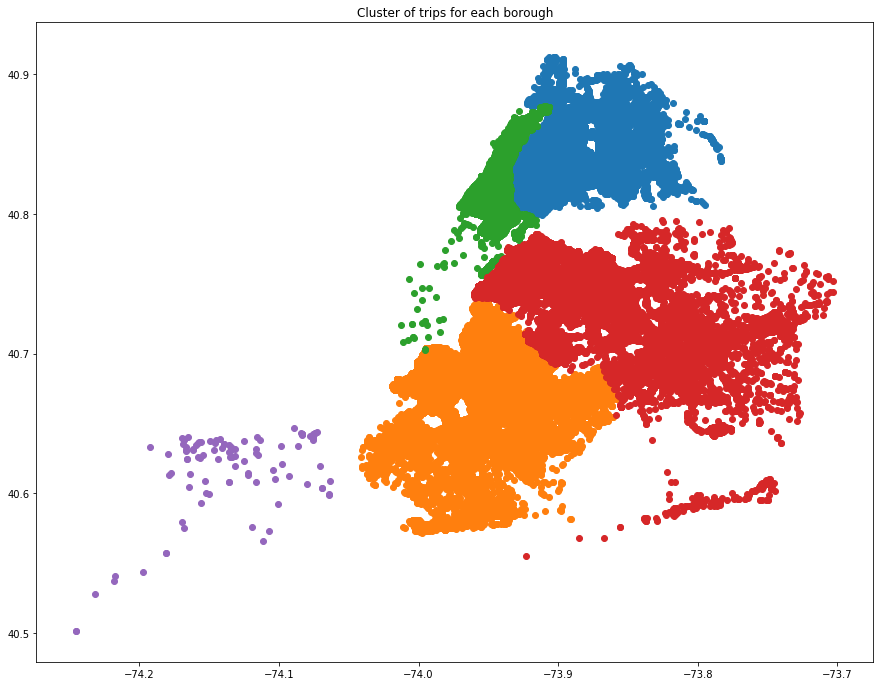

In [31]:
fig, ax = plt.subplots(figsize = (15,15))
groups = df_pickup_new.groupby('pickup_boro_name')
for name, group in groups:
    group.plot(ax=ax)

plt.title("Cluster of trips for each borough")
plt.show()

# Trip Clusters for NYC Dropoff Boroughs

In [32]:
df_dropoff_new=df_dropoff_new.rename(columns = {'dropoff_geometry':'geometry'})

In [33]:
df_dropoff_new.columns

Index(['new_index', 'geometry', 'dropoff_boro_name', 'dropoff_neighborhood'], dtype='object')

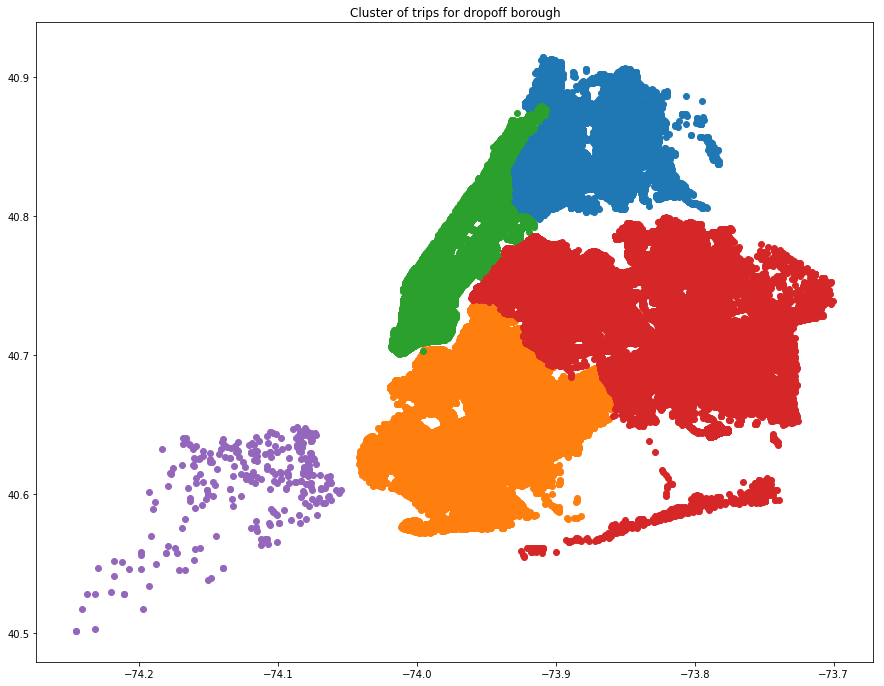

In [34]:
fig, ax = plt.subplots(figsize = (15,15))
groups = df_dropoff_new.groupby('dropoff_boro_name')
for name, group in groups:
    group.plot(ax=ax)

plt.title("Cluster of trips for dropoff borough")
plt.show()

# I am going to also make an interactive graph for all the pickup neighborhoods as well as dropoff neighborhoods on a NYC City map using Folium

In [30]:
# select the first occurrence of each neighborhood name
pickup_neighborhood_temp = df_final.groupby("pickup_neighborhood").first()
dropoff_neighborhood_temp = df_final.groupby("dropoff_neighborhood").first()

In [31]:
# and select only the columns we are interested in
pickup_neighborhood_temp = pickup_neighborhood_temp.loc[:, ["Pickup_latitude",
                              "Pickup_longitude"]]

dropoff_neighborhood_temp = dropoff_neighborhood_temp.loc[:, ["Dropoff_latitude",
                              "Dropoff_longitude"]]

In [32]:
pickup_neighborhood_temp.head()

,Pickup_latitude,Pickup_longitude
pickup_neighborhood,,
Airport,40.774,-73.871
Allerton-Pelham Gardens,40.865,-73.843
Arden Heights,40.543,-74.197
Astoria,40.767,-73.921
Auburndale,40.758,-73.790


In [33]:
pickup_neighborhood_temp = pickup_neighborhood_temp.reset_index()

In [34]:
pickup_neighborhood_temp.head()

,pickup_neighborhood,Pickup_latitude,Pickup_longitude
0,Airport,40.774,-73.871
1,Allerton-Pelham Gardens,40.865,-73.843
2,Arden Heights,40.543,-74.197
3,Astoria,40.767,-73.921
4,Auburndale,40.758,-73.790


In [35]:
dropoff_neighborhood_temp.head()

,Dropoff_latitude,Dropoff_longitude
dropoff_neighborhood,,
Airport,40.644,-73.782
Allerton-Pelham Gardens,40.859,-73.850
Annadale-Huguenot-Prince's Bay-Eltingville,40.534,-74.193
Arden Heights,40.556,-74.199
Astoria,40.756,-73.924


In [36]:
dropoff_neighborhood_temp = dropoff_neighborhood_temp.reset_index()

In [37]:
dropoff_neighborhood_temp.head()

,dropoff_neighborhood,Dropoff_latitude,Dropoff_longitude
0,Airport,40.644,-73.782
1,Allerton-Pelham Gardens,40.859,-73.850
2,Annadale-Huguenot-Prince's Bay-Eltingville,40.534,-74.193
3,Arden Heights,40.556,-74.199
4,Astoria,40.756,-73.924


In [149]:
# and select only the columns we are interested in
pickup_neighborhood = pickup_neighborhood.loc[:, ["Pickup_latitude",
                              "Pickup_longitude", "pickup_neighborhood"]]
pickup_neighborhood = pickup_neighborhood.reset_index()


dropoff_neighborhood = dropoff_neighborhood.loc[:, ["Dropoff_latitude",
                              "Dropoff_longitude", "dropoff_neighborhood"]]
dropoff_neighborhood = dropoff_neighborhood.reset_index()

In [150]:
dropoff_neighborhood.head()

,index,Dropoff_latitude,Dropoff_longitude
0,0,40.644,-73.782
1,1,40.859,-73.850
2,2,40.534,-74.193
3,3,40.556,-74.199
4,4,40.756,-73.924


In [51]:
#The color blue is the pickup neighborhood and Green is dropoff neighborhood
import folium
NYC_city_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13)

for index, row in pickup_neighborhood_temp.iterrows():
    folium.CircleMarker([row['Pickup_latitude'], row['Pickup_longitude']],
                        radius=10,
                        popup=row['pickup_neighborhood'],
                        color="#3db7e4", # divvy color
                       ).add_to(NYC_city_map)
    
for index, row in dropoff_neighborhood_temp.iterrows():
    folium.CircleMarker([row['Dropoff_latitude'], row['Dropoff_longitude']],
                        radius=10,
                        popup=row['dropoff_neighborhood'],
                        fill=False,
                        color="#007849", # divvy color
                       ).add_to(NYC_city_map)

In [52]:
NYC_city_map

# It is very interesting to note that even though NYC Green Taxis are not allowed to pickup passengers in Upper Manhattan area, there is still a fair share of drop-offs in those areas knowing that Taxi drivers might not get any passengers on their return trip. I will also examine the busiest pickup and dropoff boroughs

In [53]:
df_final.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index',
       'pickup_geometry', 'pickup_boro_name', 'pickup_neighborhood',
       'dropoff_geometry', 'dropoff_boro_name', 'dropoff_neighborhood'],
      dtype='object')

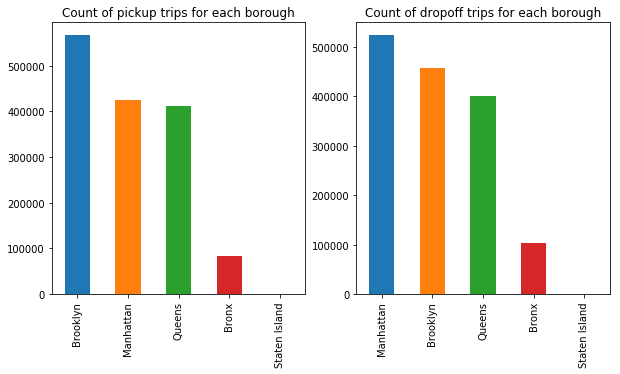

In [54]:
# define the figure with 2 subplots
fig, ax = plt.subplots(1,2,figsize = (15,4)) 

# barplot to represent the busiest pickup borough
df_final["pickup_boro_name"].value_counts().plot(kind = "bar", ax = ax[0], figsize=(10,5), title = "Count of pickup trips for each borough")

#histogram of number of trip distance without outliers
df_final["dropoff_boro_name"].value_counts().plot(kind = "bar", ax= ax[1], figsize=(10,5), title = "Count of dropoff trips for each borough")


plt.show()

# The above graph indicates that Brooklyn has the highest number of pickups but Manhattan has the highest number of dropoffs. To understand further about the movement of traffic among boroughs. I will create a heatmap

In [55]:
df_hm = df_final.groupby(['pickup_boro_name', 'dropoff_boro_name'], as_index=False)['new_index'].count()

In [56]:
df_hm.head()

,pickup_boro_name,dropoff_boro_name,new_index
0,Bronx,Bronx,63082
1,Bronx,Brooklyn,445
2,Bronx,Manhattan,18487
3,Bronx,Queens,1561
4,Bronx,Staten Island,1


In [57]:
set(zip(df_hm['pickup_boro_name'], df_hm['dropoff_boro_name']))

{('Bronx', 'Bronx'),
 ('Bronx', 'Brooklyn'),
 ('Bronx', 'Manhattan'),
 ('Bronx', 'Queens'),
 ('Bronx', 'Staten Island'),
 ('Brooklyn', 'Bronx'),
 ('Brooklyn', 'Brooklyn'),
 ('Brooklyn', 'Manhattan'),
 ('Brooklyn', 'Queens'),
 ('Brooklyn', 'Staten Island'),
 ('Manhattan', 'Bronx'),
 ('Manhattan', 'Brooklyn'),
 ('Manhattan', 'Manhattan'),
 ('Manhattan', 'Queens'),
 ('Manhattan', 'Staten Island'),
 ('Queens', 'Bronx'),
 ('Queens', 'Brooklyn'),
 ('Queens', 'Manhattan'),
 ('Queens', 'Queens'),
 ('Queens', 'Staten Island'),
 ('Staten Island', 'Brooklyn'),
 ('Staten Island', 'Manhattan'),
 ('Staten Island', 'Queens'),
 ('Staten Island', 'Staten Island')}

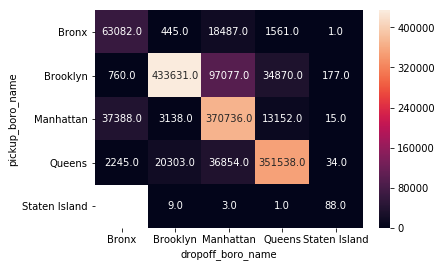

In [58]:
df_pivot = df_hm.pivot_table(index='pickup_boro_name', columns = 'dropoff_boro_name', values = 'new_index')
sns.heatmap(df_pivot, annot = True, fmt=".1f")
plt.show()

# The above heat map shows that the traffic moves within the boroughs in highly dense areas of Manhattan, Queens and Brooklyn and there is no trips originating in Staten Island and ending at Bronx whereas the maximum inter borough traffic is flowing from Brooklyn to Manhattan

# In order to understand the congestion of traffic, we will further see the distribution of distance and time according to the origin borough and dropoff borough. We will check the average speed for all pickups and dropoffs combination. We will use the pickup datetime and dropoff datetime field to calculate time lapsed for each trip. We will also extract the week and hour of the day information from the datetime information

In [59]:
#extracting all necessary information from pickup and dropoff datetime
df_final['lpep_pickup_datetime'] = pd.to_datetime(df_final['lpep_pickup_datetime'])
df_final['Lpep_dropoff_datetime'] = pd.to_datetime(df_final['Lpep_dropoff_datetime'])

df_final['Pickup_Hour'] = df_final['lpep_pickup_datetime'].dt.hour
df_final['Dropoff_Hour'] = df_final['Lpep_dropoff_datetime'].dt.hour

df_final['Dropoff_Week'] = df_final['Lpep_dropoff_datetime'].dt.weekday
df_final['Pickup_Week'] = df_final['lpep_pickup_datetime'].dt.weekday

df_final['Trip_time'] = (df_final['Lpep_dropoff_datetime'] - df_final['lpep_pickup_datetime']).apply(lambda x: x.total_seconds())

In [173]:
df_final['Trip_distance'].describe()

count   1461913.000
mean          2.975
std           2.941
min           0.000
25%           1.110
50%           2.000
75%           3.760
max         603.100
Name: Trip_distance, dtype: float64

In [174]:
df_final['Trip_time'].describe()

count   1461913.000
mean       1231.568
std        5856.428
min          61.000
25%         382.000
50%         634.000
75%        1042.000
max       86394.000
Name: Trip_time, dtype: float64

In [181]:
#calculating speed of the trips

df_final['Speed'] = (df_final['Trip_distance']/df_final['Trip_time'])*3600

In [182]:
df_speed = df_final.groupby(['pickup_boro_name', 'dropoff_boro_name'], as_index=False)['Speed'].agg(['mean', 'median'])

In [183]:
df_speed = df_speed.reset_index()
df_speed.head()

,pickup_boro_name,dropoff_boro_name,mean,median
0,Bronx,Bronx,12.900,11.681
1,Bronx,Brooklyn,23.456,22.761
2,Bronx,Manhattan,14.311,12.758
3,Bronx,Queens,25.490,25.108
4,Bronx,Staten Island,20.583,20.583


In [188]:
from tabulate import tabulate

print("The mean and median speed for inter vs intra borough trips")
print(tabulate(df_speed, headers='keys', tablefmt='psql'))

The mean and median speed for inter vs intra borough trips
+----+--------------------+---------------------+---------+----------+
|    | pickup_boro_name   | dropoff_boro_name   |    mean |   median |
|----+--------------------+---------------------+---------+----------|
|  0 | Bronx              | Bronx               | 12.9003 |  11.6814 |
|  1 | Bronx              | Brooklyn            | 23.4557 |  22.7611 |
|  2 | Bronx              | Manhattan           | 14.3113 |  12.7582 |
|  3 | Bronx              | Queens              | 25.4898 |  25.1077 |
|  4 | Bronx              | Staten Island       | 20.5834 |  20.5834 |
|  5 | Brooklyn           | Bronx               | 24.3666 |  24.5106 |
|  6 | Brooklyn           | Brooklyn            | 11.676  |  11.2186 |
|  7 | Brooklyn           | Manhattan           | 14.0374 |  13.561  |
|  8 | Brooklyn           | Queens              | 18.4701 |  16.9219 |
|  9 | Brooklyn           | Staten Island       | 25.6982 |  25.1476 |
| 10 | Manhattan  

# Distribution of Trip Distance Originating at Brooklyn

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


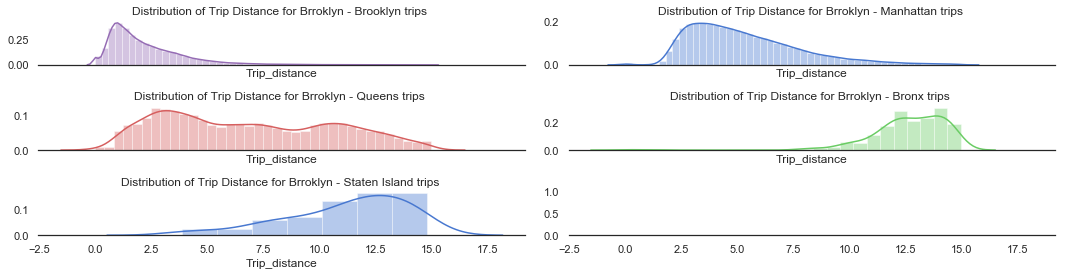

In [61]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Distance for Brroklyn - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Distance for Brroklyn - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Distance for Brroklyn - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Distance for Brroklyn - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Distance for Brroklyn - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# Distribution of Trip Distance Originating at Manhattan

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


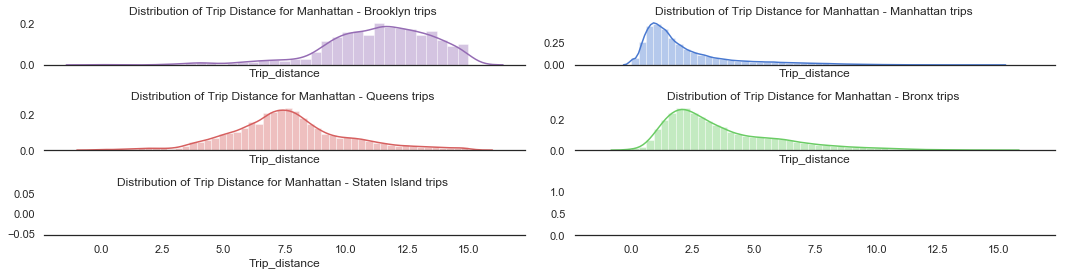

In [62]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Distance for Manhattan - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Distance for Manhattan - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Distance for Manhattan - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Distance for Manhattan - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Distance for Manhattan - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# Distribution of Trip Distance Originating at Queens

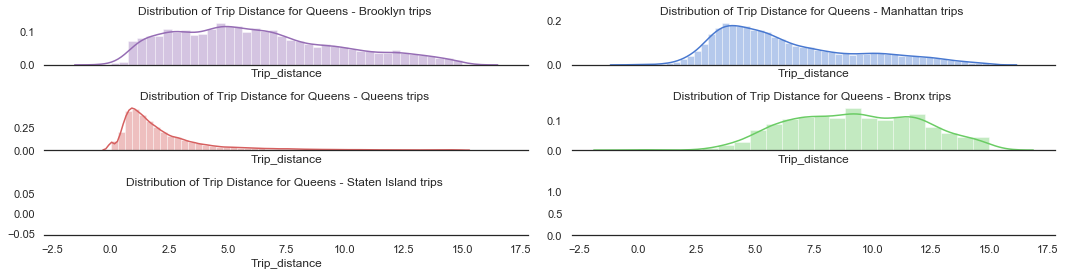

In [63]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Distance for Queens - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Distance for Queens - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Distance for Queens - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Distance for Queens - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Distance for Queens - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# Distribution of Trip Distance Originating at Bronx

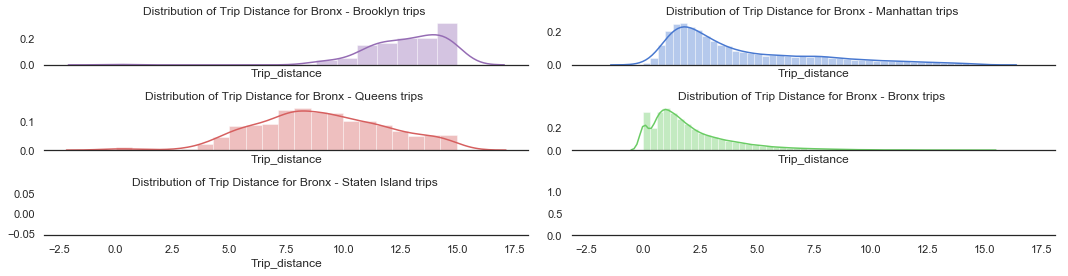

In [64]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Distance for Bronx - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Distance for Bronx - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Distance for Bronx - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Distance for Bronx - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Distance for Bronx - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# Distribution of Trip Distance Originating at Staten Island

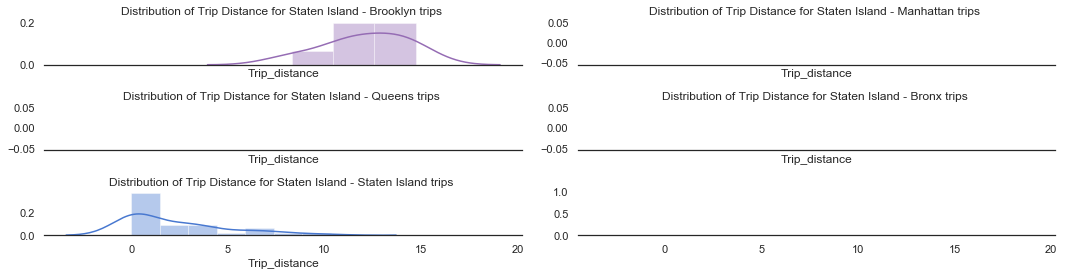

In [65]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Distance for Staten Island - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Distance for Staten Island - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Distance for Staten Island - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Distance for Staten Island - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_distance'] < 15) ]
sns.distplot(subset['Trip_distance'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Distance for Staten Island - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# Similarly we will see the distribution of Trip Time for each inter vs intra borough

In [66]:
df_final['Trip_time'].describe()

count   1485595.000
mean       1212.261
std        5811.542
min           0.000
25%         371.000
50%         625.000
75%        1033.000
max       86394.000
Name: Trip_time, dtype: float64

In [67]:
print('Percentage of entries with travel time less than a minute: ',100 * df_final[df_final['Trip_time'] < 60].shape[0]/df.shape[0],'%')

Percentage of entries with travel time less than a minute:  1.5669003014196021 %


Removing trips taking less than 60 seconds since they are anamolies and can affect our analysis. 1.5% of the data are less than 60 seconds. I am dropping these rows.

In [68]:
df_final = df_final[df_final['Trip_time'] > 60]

In [69]:
df_final['Trip_time'].describe()

count   1461913.000
mean       1231.568
std        5856.428
min          61.000
25%         382.000
50%         634.000
75%        1042.000
max       86394.000
Name: Trip_time, dtype: float64

# Distribution of Trip Time for Trips Originating at Brooklyn

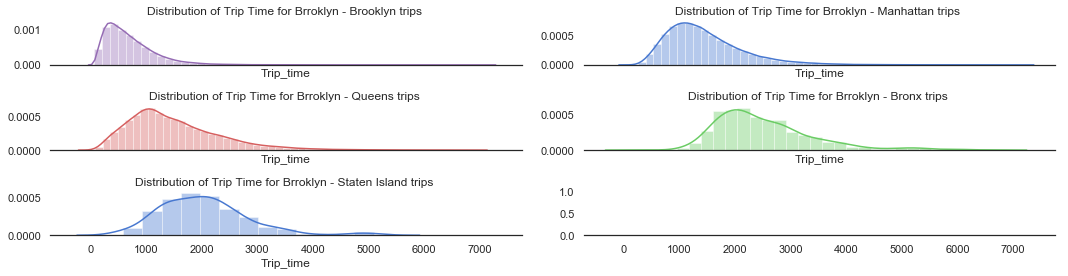

In [70]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_time'] < 7200)  ]
sns.distplot(subset['Trip_time'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Time for Brroklyn - Brooklyn trips ")


subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Time for Brroklyn - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Time for Brroklyn - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Time for Brroklyn - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Brooklyn') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Time for Brroklyn - Staten Island trips ")



plt.setp(ax, yticks=[])
plt.tight_layout()

# Distribution of Trip Time for Trips Originating at Manhattan

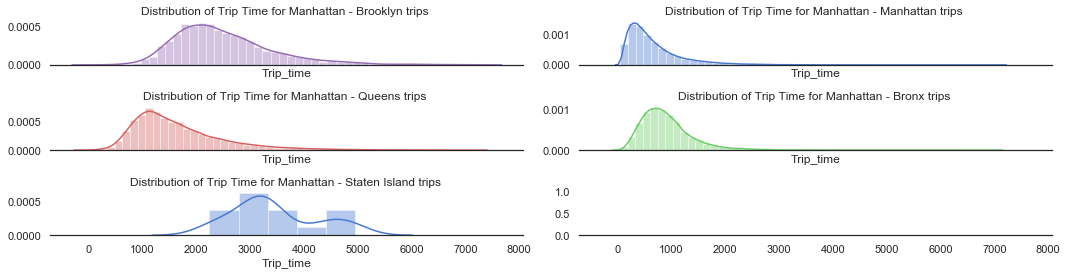

In [71]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Time for Manhattan - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Time for Manhattan - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Time for Manhattan - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Time for Manhattan - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Manhattan') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Time for Manhattan - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# Distribution of Trip Time for Trips Originating at Queens

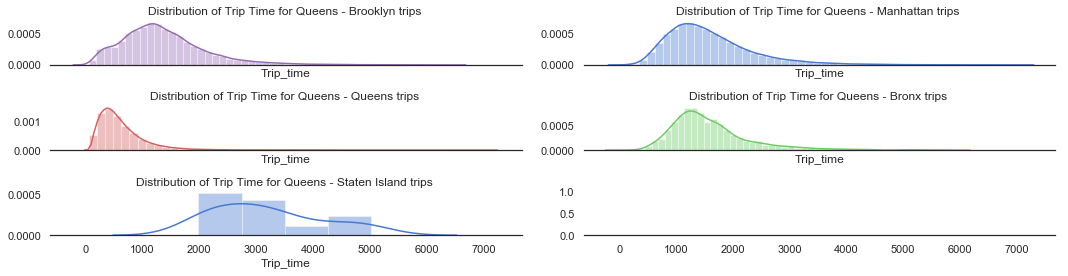

In [72]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Time for Queens - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Time for Queens - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Time for Queens - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Time for Queens - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Queens') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Time for Queens - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# Distribution of Trip Time for Trips Originating at Bronx

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


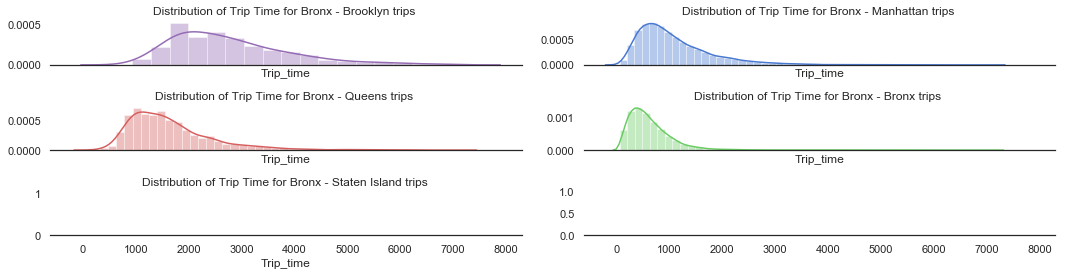

In [73]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Time for Bronx - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Time for Bronx - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Time for Bronx - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Time for Bronx - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Bronx') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Time for Bronx - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# Distribution of Trip Time for Trips Originating at Staten Island

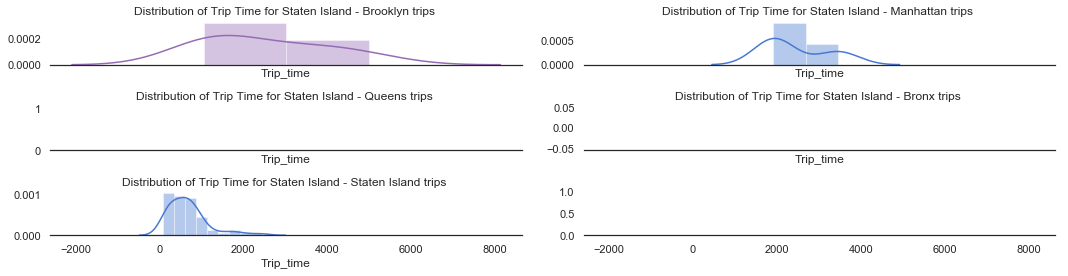

In [74]:
# define the figure with  subplots
sns.set(style="white", palette="muted", color_codes=True)
#rs = np.random.RandomState(10)
f, axes = plt.subplots(3, 2, figsize=(15, 4), sharex=True)
sns.despine(left=True)


subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Brooklyn') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "m", ax = axes[0,0]).set_title("Distribution of Trip Time for Staten Island - Brooklyn trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Manhattan') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[0,1]).set_title("Distribution of Trip Time for Staten Island - Manhattan trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Queens') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "r", ax = axes[1,0]).set_title("Distribution of Trip Time for Staten Island - Queens trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Bronx') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "g", ax = axes[1,1]).set_title("Distribution of Trip Time for Staten Island - Bronx trips ")

subset = df_final[(df_final['pickup_boro_name'] == 'Staten Island') & (df_final['dropoff_boro_name'] == 'Staten Island') & (df_final['Trip_time'] < 7200) ]
sns.distplot(subset['Trip_time'], color = "b", ax = axes[2,0]).set_title("Distribution of Trip Time for Staten Island - Staten Island trips ")


plt.setp(ax, yticks=[])
plt.tight_layout()

# To understand how traffic flows throughout the day for each borough, I will create a lineplot of the number of trips throughout the day based on their pickup borough and dropoff borough

In [75]:
df_final.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index',
       'pickup_geometry', 'pickup_boro_name', 'pickup_neighborhood',
       'dropoff_geometry', 'dropoff_boro_name', 'dropoff_neighborhood',
       'Pickup_Hour', 'Dropoff_Hour', 'Dropoff_Week', 'Pickup_Week',
       'Trip_time'],
      dtype='object')

In [76]:
df_pickup_boro = df_final.groupby(['pickup_boro_name', 'Pickup_Hour'], as_index=False)['new_index'].count()
df_dropoff_boro = df_final.groupby(['dropoff_boro_name', 'Dropoff_Hour'], as_index=False)['new_index'].count()

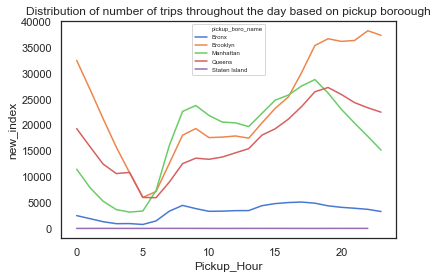

In [77]:
sns.set(style="white", palette="muted", color_codes=True)
sns.despine(left=True)

sns.lineplot('Pickup_Hour', 'new_index', data=df_pickup_boro, hue='pickup_boro_name').set_title('Distribution of number of trips throughout the day based on pickup boroough')

plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Hour of the day"

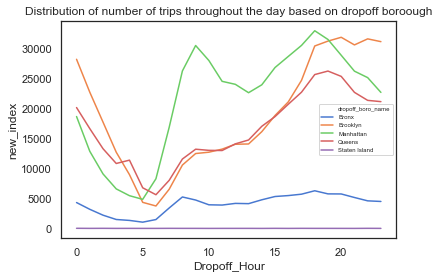

In [78]:
sns.set(style="white", palette="muted", color_codes=True)
sns.despine(left=True)

sns.lineplot('Dropoff_Hour', 'new_index', data=df_dropoff_boro, hue='dropoff_boro_name').set_title('Distribution of number of trips throughout the day based on dropoff boroough')

plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Hour of the day"

# To understand how traffic flows throughout the week for each borough, I will create a lineplot of the number of trips throughout the week based on their pickup borough and dropoff borough

In [79]:
df_pickup_week_boro = df_final.groupby(['pickup_boro_name', 'Pickup_Week'], as_index=False)['new_index'].count()
df_dropoff_week_boro = df_final.groupby(['dropoff_boro_name', 'Dropoff_Week'], as_index=False)['new_index'].count()

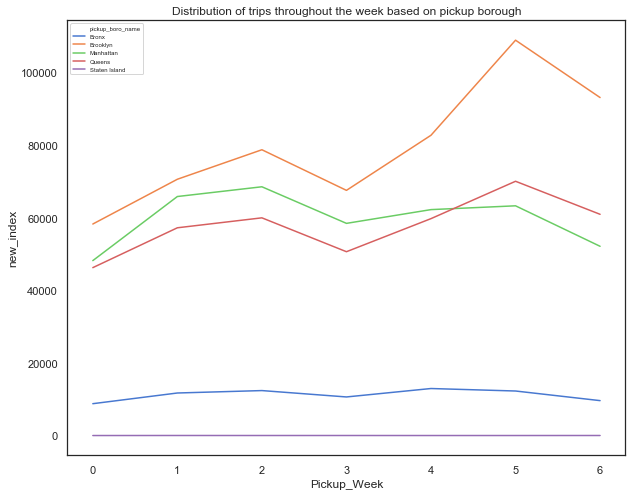

In [80]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Week', 'new_index', data=df_pickup_week_boro, hue='pickup_boro_name')
plt.title("Distribution of trips throughout the week based on pickup borough")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the week"

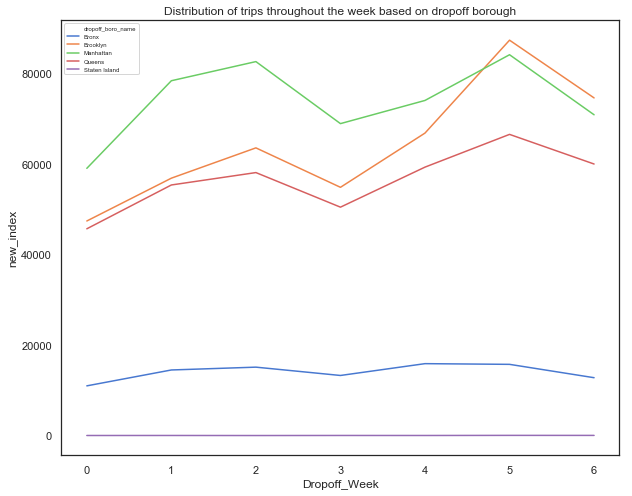

In [81]:
plt.figure(figsize=(10, 8))
sns.lineplot('Dropoff_Week', 'new_index', data=df_dropoff_week_boro, hue='dropoff_boro_name')
plt.title("Distribution of trips throughout the week based on dropoff borough")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the week"

# In the below section, we will look further into intra borough traffic, since majority of the trips are intra borough traffic. Firstly, I will extract the top 5 busiest neighborhood for each borough based on pickup borough and pickup neighborhood information

In [82]:
df_temp = df_final.groupby(['pickup_boro_name', 'pickup_neighborhood'])['new_index'].agg({'count':'count'})
df_temp

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


count
pickup_boro_name pickup_neighborhood                                      
Bronx            Allerton-Pelham Gardens                               198
                 Bedford Park-Fordham North                           2624
                 Belmont                                              2327
                 Bronxdale                                             451
                 Claremont-Bathgate                                   1935
                 Co-op City                                            306
                 Crotona Park East                                     968
                 East Concourse-Concourse Village                     5687
                 East Tremont                                         1965
                 Eastchester-Edenwald-Baychester                       171
                 Fordham South                                        1323
                 Highbridge                                           2674
                 Hunts Point                                          1329
                 Kingsbridge Heights                                  1584
                 Longwood                                             1228
                 Melrose South-Mott Haven North                       6328
                 Morrisania-Melrose                                   2405
                 Mott Haven-Port Morris                               6216
                 Mount Hope                                           2631
                 North Riverdale-Fieldston-Riverdale                   168
                 Norwood                                              2919
                 Parkchester                                          2626
                 Pelham Bay-Country Club-City Island                   620
                 Pelham Parkway                                       1325
                 Schuylerville-Throgs Neck-Edgewater Park              576
                 Soundview-Bruckner                                   1967
                 Soundview-Castle Hill-Clason Point-Harding Park       926
                 Spuyten Duyvil-Kingsbridge                           2129
                 University Heights-Morris Heights                    2023
                 Van Cortlandt Village                                1690
...                                                                    ...
Queens           Pomonok-Flushing Heights-Hillcrest                   1064
                 Queens Village                                        182
                 Queensboro Hill                                       923
                 Queensbridge-Ravenswood-Long Island City            10632
                 Rego Park                                           10967
                 Richmond Hill                                        1023
                 Ridgewood                                             990
                 Rosedale                                               26
                 South Jamaica                                         214
                 South Ozone Park                                      844
                 Springfield Gardens North                              92
                 Springfield Gardens South-Brookville                   50
                 St. Albans                                             80
                 Steinway                                            24093
                 Whitestone                                             56
                 Woodhaven                                             402
                 Woodside                                            28421
                 park-cemetery-etc-Queens                            11233
Staten Island    Charleston-Richmond Valley-Tottenville                  2
                 Grasmere-Arrochar-Ft. Wadsworth                         2
                 Grymes Hill-Clifton-Fox Hills                           1
                 Ma

# I will make a bar graph  for better visualization

In [83]:
g = df_temp["count"].groupby(level = 0, group_keys=False)
df_intra = pd.DataFrame(g.nlargest(5))
df_intra.reset_index(inplace=True)

In [84]:
df_intra.columns

Index(['pickup_boro_name', 'pickup_neighborhood', 'count'], dtype='object')

In [85]:
df_intra.columns = ['pickup_boro_name', 'pickup_neighborhood', 'trips_count']

In [86]:
df_intra_Brooklyn = df_intra[df_intra.pickup_boro_name == "Brooklyn"]
df_intra_Manhattan = df_intra[df_intra.pickup_boro_name == "Manhattan"]
df_intra_Queens = df_intra[df_intra.pickup_boro_name == "Queens"]
df_intra_Bronx = df_intra[df_intra.pickup_boro_name == "Bronx"]
df_intra_Staten = df_intra[df_intra.pickup_boro_name == "Staten Island"]

Text(0.5, 1.0, 'Staten Island')

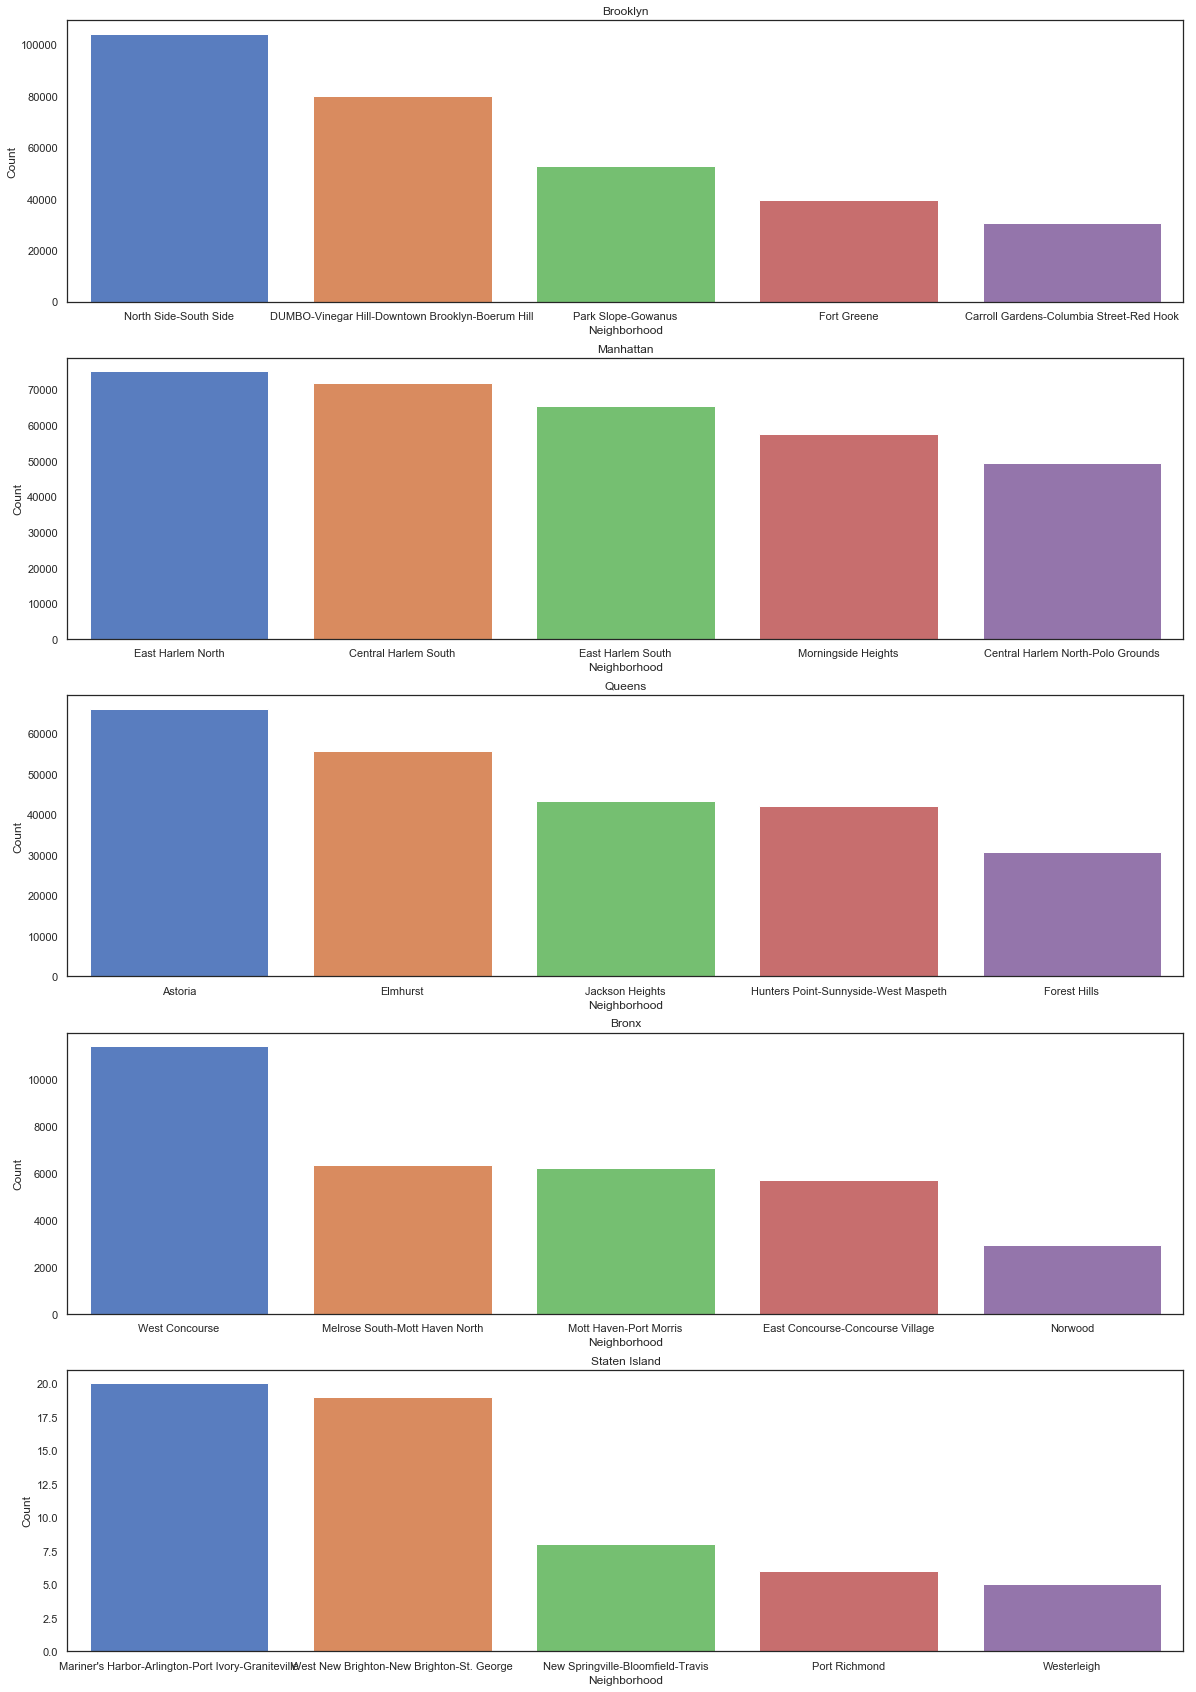

In [87]:
plt.figure(figsize=(20, 30))

plt.subplot(5, 1, 1)
ax = sns.barplot('pickup_neighborhood', 'trips_count', data = df_intra_Brooklyn )
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Count')
ax.set_title('Brooklyn')

plt.subplot(5, 1, 2)
ax = sns.barplot('pickup_neighborhood', 'trips_count', data = df_intra_Manhattan )
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Count')
ax.set_title('Manhattan')

plt.subplot(5, 1, 3)
ax = sns.barplot('pickup_neighborhood', 'trips_count', data = df_intra_Queens )
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Count')
ax.set_title('Queens')

plt.subplot(5, 1, 4)
ax = sns.barplot('pickup_neighborhood', 'trips_count', data = df_intra_Bronx )
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Count')
ax.set_title('Bronx')

plt.subplot(5, 1, 5)
ax = sns.barplot('pickup_neighborhood', 'trips_count', data = df_intra_Staten )
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Count')
ax.set_title('Staten Island')


# In order to understand the intra-borough traffic, we will explore the traffic flow of green taxi throughout the day and for each day of the week, one borough at a time. For this section we will only examine the intra borough trips.

In [88]:
#To get started we will create a DataFrame for each intra-borough trips

df_Manhattan = df_final[(df_final['pickup_boro_name'] == "Manhattan") & (df_final['dropoff_boro_name'] == "Manhattan")]
df_Brooklyn = df_final[(df_final['pickup_boro_name'] == "Brooklyn") & (df_final['dropoff_boro_name'] == "Brooklyn")]
df_Queens = df_final[(df_final['pickup_boro_name'] == "Queens") & (df_final['dropoff_boro_name'] == "Queens")]
df_Bronx = df_final[(df_final['pickup_boro_name'] == "Bronx") & (df_final['dropoff_boro_name'] == "Bronx")]
df_Staten = df_final[(df_final['pickup_boro_name'] == "Staten Island") & (df_final['dropoff_boro_name'] == "Staten Island")]

In [89]:
df_Manhattan.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,pickup_boro_name,pickup_neighborhood,dropoff_geometry,dropoff_boro_name,dropoff_neighborhood,Pickup_Hour,Dropoff_Hour,Dropoff_Week,Pickup_Week,Trip_time
251853,2,2015-09-01 00:00:39,2015-09-01 00:05:20,N,1,-73.945,40.808,-73.938,40.821,1,...,Manhattan,Central Harlem South,POINT (-73.93766784667969 40.82119750976562),Manhattan,Central Harlem North-Polo Grounds,0,0,1,1,281.000
251854,2,2015-09-01 00:04:59,2015-09-01 00:07:27,N,1,-73.953,40.808,-73.949,40.803,1,...,Manhattan,Central Harlem South,POINT (-73.94914245605469 40.80290985107422),Manhattan,Central Harlem South,0,0,1,1,148.000
251855,2,2015-09-01 00:01:32,2015-09-01 00:07:27,N,1,-73.947,40.806,-73.936,40.799,1,...,Manhattan,Central Harlem South,POINT (-73.93624877929686 40.79925155639648),Manhattan,East Harlem North,0,0,1,1,355.000
251856,2,2015-09-01 00:04:51,2015-09-01 00:08:09,N,1,-73.952,40.803,-73.941,40.818,1,...,Manhattan,Central Harlem South,POINT (-73.94136047363281 40.81830596923828),Manhattan,Central Harlem North-Polo Grounds,0,0,1,1,198.000
251857,2,2015-09-01 00:07:38,2015-09-01 00:09:28,N,1,-73.953,40.808,-73.950,40.810,1,...,Manhattan,Central Harlem South,POINT (-73.9495391845703 40.8095932006836),Manhattan,Central Harlem South,0,0,1,1,110.000


# Similar to inter borough traffic, I will plot lineplot for the counts of trips for hour of the day and day of the week. 

In [97]:
df_Manhattan.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'new_index',
       'pickup_geometry', 'pickup_boro_name', 'pickup_neighborhood',
       'dropoff_geometry', 'dropoff_boro_name', 'dropoff_neighborhood',
       'Pickup_Hour', 'Dropoff_Hour', 'Dropoff_Week', 'Pickup_Week',
       'Trip_time'],
      dtype='object')

In [100]:
df_manhattan_nb = df_Manhattan.groupby(['pickup_neighborhood', 'Pickup_Hour'], as_index=False)['new_index'].count()

In [104]:
df_manhattan_nb.columns= ['pickup_neighborhood', 'Pickup_Hour', 'Trip_Counts']
df_manhattan_nb.head()

,pickup_neighborhood,Pickup_Hour,Trip_Counts
0,Battery Park City-Lower Manhattan,14,1
1,Battery Park City-Lower Manhattan,22,1
2,Central Harlem North-Polo Grounds,0,1338
3,Central Harlem North-Polo Grounds,1,1037
4,Central Harlem North-Polo Grounds,2,715


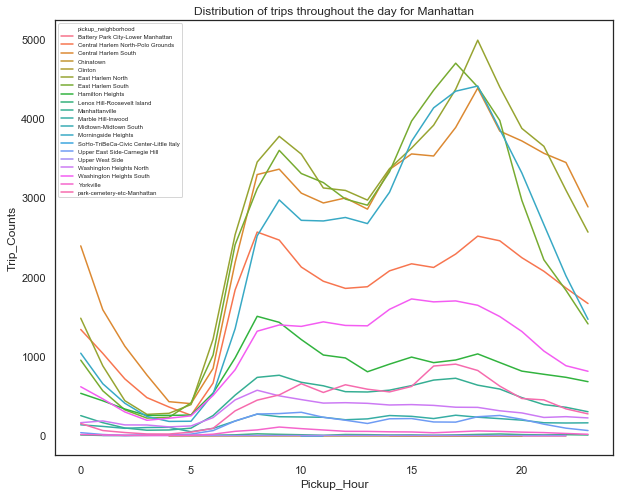

In [106]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Hour', 'Trip_Counts', data=df_manhattan_nb, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the day for Manhattan")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Hour of the day"

In [107]:
df_manhattan_nb_week = df_Manhattan.groupby(['pickup_neighborhood', 'Pickup_Week'], as_index=False)['new_index'].count()
df_manhattan_nb_week.columns= ['pickup_neighborhood', 'Pickup_Week', 'Trip_Counts']

In [108]:
df_manhattan_nb_week.head()

,pickup_neighborhood,Pickup_Week,Trip_Counts
0,Battery Park City-Lower Manhattan,0,1
1,Battery Park City-Lower Manhattan,1,1
2,Central Harlem North-Polo Grounds,0,4434
3,Central Harlem North-Polo Grounds,1,5994
4,Central Harlem North-Polo Grounds,2,6423


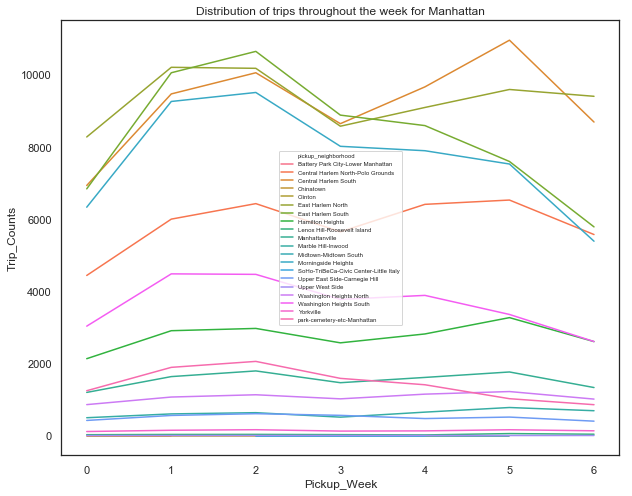

In [109]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Week', 'Trip_Counts', data=df_manhattan_nb_week, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the week for Manhattan")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the week"

In [115]:
df_Brooklyn_nb = df_Brooklyn.groupby(['pickup_neighborhood', 'Pickup_Hour'], as_index=False)['new_index'].count()
df_Brooklyn_nb.columns= ['pickup_neighborhood', 'Pickup_Hour', 'Trip_Counts']

In [116]:
df_Brooklyn_nb.head()

,pickup_neighborhood,Pickup_Hour,Trip_Counts
0,Bath Beach,0,3
1,Bath Beach,3,1
2,Bath Beach,4,1
3,Bath Beach,5,1
4,Bath Beach,8,1


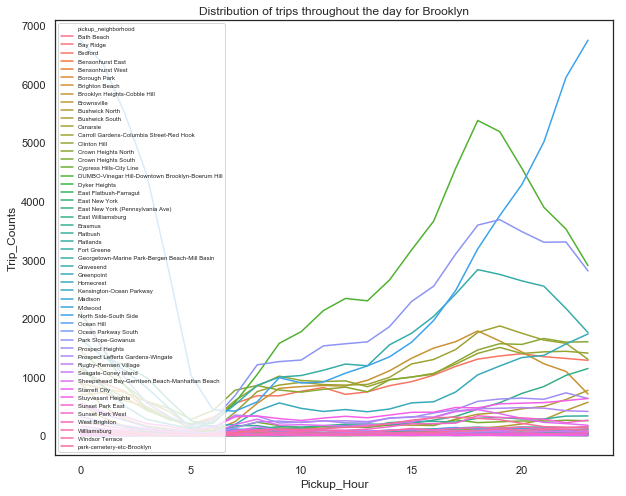

In [117]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Hour', 'Trip_Counts', data=df_Brooklyn_nb, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the day for Brooklyn")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the Hour"

In [118]:
df_Brooklyn_nb_week = df_Brooklyn.groupby(['pickup_neighborhood', 'Pickup_Week'], as_index=False)['new_index'].count()
df_Brooklyn_nb_week.columns= ['pickup_neighborhood', 'Pickup_Week', 'Trip_Counts']

In [119]:
df_Brooklyn_nb_week.head()

,pickup_neighborhood,Pickup_Week,Trip_Counts
0,Bath Beach,0,5
1,Bath Beach,1,6
2,Bath Beach,2,3
3,Bath Beach,3,6
4,Bath Beach,4,9


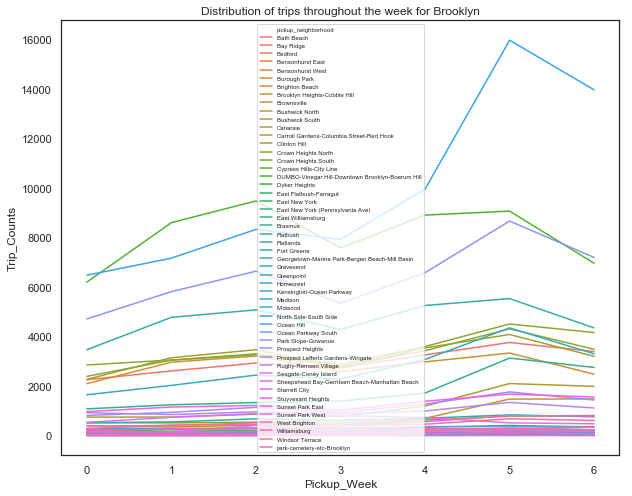

In [121]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Week', 'Trip_Counts', data=df_Brooklyn_nb_week, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the week for Brooklyn")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the week"

In [122]:
df_Bronx_nb= df_Bronx.groupby(['pickup_neighborhood', 'Pickup_Hour'], as_index=False)['new_index'].count()
df_Bronx_nb.columns= ['pickup_neighborhood', 'Pickup_Hour', 'Trip_Counts']

In [123]:
df_Bronx_nb.head()

,pickup_neighborhood,Pickup_Hour,Trip_Counts
0,Allerton-Pelham Gardens,0,2
1,Allerton-Pelham Gardens,1,6
2,Allerton-Pelham Gardens,2,4
3,Allerton-Pelham Gardens,3,1
4,Allerton-Pelham Gardens,4,3


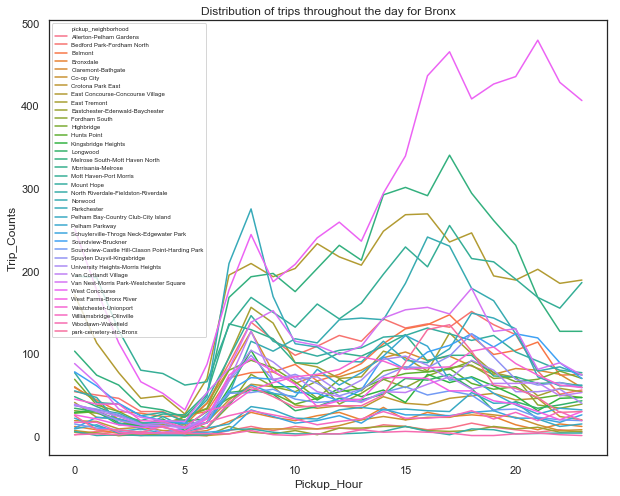

In [124]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Hour', 'Trip_Counts', data=df_Bronx_nb, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the day for Bronx")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the Hour"

In [125]:
df_Bronx_nb_week= df_Bronx.groupby(['pickup_neighborhood', 'Pickup_Week'], as_index=False)['new_index'].count()
df_Bronx_nb_week.columns= ['pickup_neighborhood', 'Pickup_Week', 'Trip_Counts']

In [126]:
df_Bronx_nb_week.head()

,pickup_neighborhood,Pickup_Week,Trip_Counts
0,Allerton-Pelham Gardens,0,26
1,Allerton-Pelham Gardens,1,25
2,Allerton-Pelham Gardens,2,27
3,Allerton-Pelham Gardens,3,29
4,Allerton-Pelham Gardens,4,29


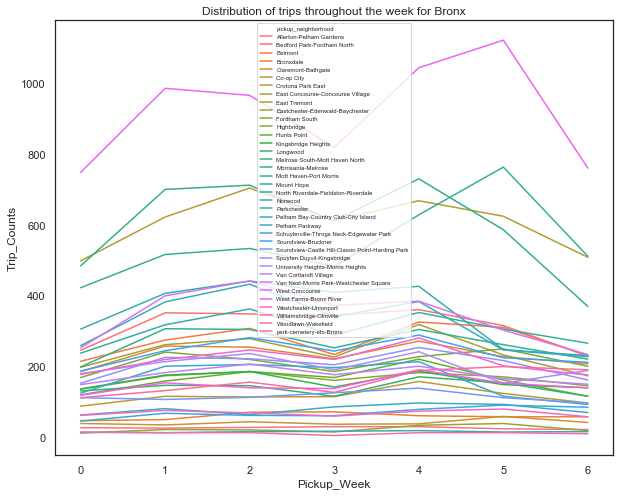

In [127]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Week', 'Trip_Counts', data=df_Bronx_nb_week, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the week for Bronx")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the week"

In [128]:
df_Queens_nb= df_Queens.groupby(['pickup_neighborhood', 'Pickup_Hour'], as_index=False)['new_index'].count()
df_Queens_nb.columns= ['pickup_neighborhood', 'Pickup_Hour', 'Trip_Counts']

In [129]:
df_Queens_nb.head()

,pickup_neighborhood,Pickup_Hour,Trip_Counts
0,Airport,0,5
1,Airport,1,2
2,Airport,2,2
3,Airport,3,6
4,Airport,4,6


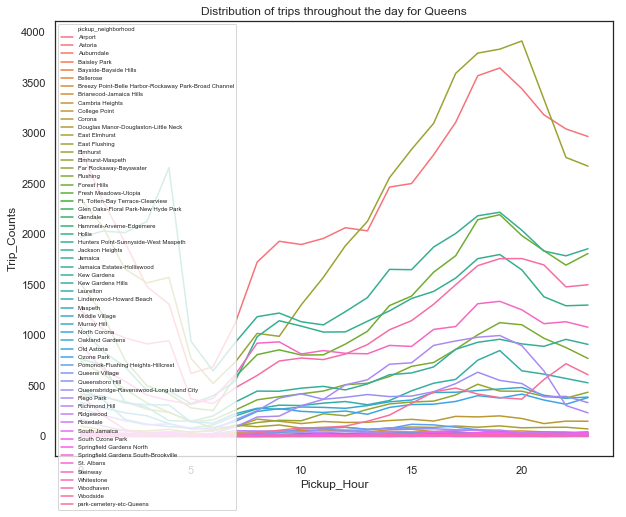

In [130]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Hour', 'Trip_Counts', data=df_Queens_nb, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the day for Queens")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the Hour"

In [133]:
df_Queens_nb_week= df_Queens.groupby(['pickup_neighborhood', 'Pickup_Week'], as_index=False)['new_index'].count()
df_Queens_nb_week.columns= ['pickup_neighborhood', 'Pickup_Week', 'Trip_Counts']

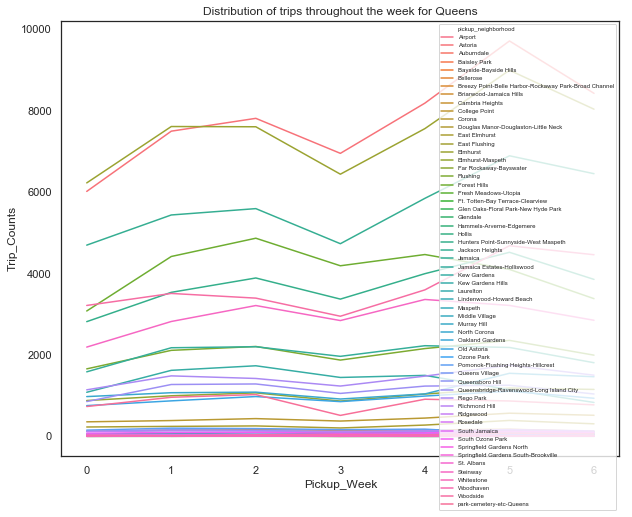

In [134]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Week', 'Trip_Counts', data=df_Queens_nb_week, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the week for Queens")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the week"

In [135]:
df_Staten_nb= df_Staten.groupby(['pickup_neighborhood', 'Pickup_Hour'], as_index=False)['new_index'].count()
df_Staten_nb.columns= ['pickup_neighborhood', 'Pickup_Hour', 'Trip_Counts']

In [136]:
df_Staten_nb.head()

,pickup_neighborhood,Pickup_Hour,Trip_Counts
0,Grasmere-Arrochar-Ft. Wadsworth,2,1
1,Grasmere-Arrochar-Ft. Wadsworth,17,1
2,Grymes Hill-Clifton-Fox Hills,4,1
3,Mariner's Harbor-Arlington-Port Ivory-Granitev...,2,1
4,Mariner's Harbor-Arlington-Port Ivory-Granitev...,6,4


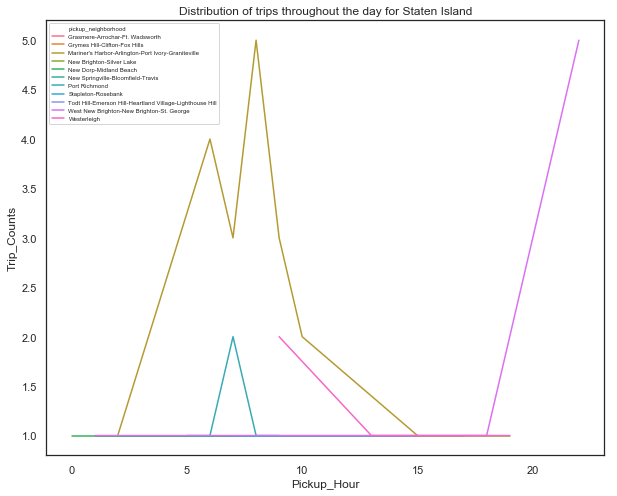

In [137]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Hour', 'Trip_Counts', data=df_Staten_nb, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the day for Staten Island")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the Hour"

In [141]:
df_Staten_nb_week= df_Staten.groupby(['pickup_neighborhood', 'Pickup_Week'], as_index=False)['new_index'].count()
df_Staten_nb_week.columns= ['pickup_neighborhood', 'Pickup_Week', 'Trip_Counts']

In [142]:
df_Staten_nb_week.head()

,pickup_neighborhood,Pickup_Week,Trip_Counts
0,Grasmere-Arrochar-Ft. Wadsworth,1,1
1,Grasmere-Arrochar-Ft. Wadsworth,6,1
2,Grymes Hill-Clifton-Fox Hills,6,1
3,Mariner's Harbor-Arlington-Port Ivory-Granitev...,0,2
4,Mariner's Harbor-Arlington-Port Ivory-Granitev...,1,9


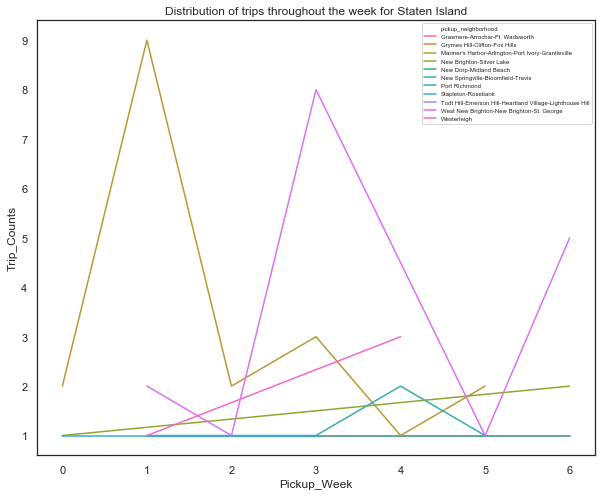

In [144]:
plt.figure(figsize=(10, 8))
sns.lineplot('Pickup_Week', 'Trip_Counts', data=df_Staten_nb_week, hue='pickup_neighborhood')
plt.title("Distribution of trips throughout the week for Staten Island")
plt.legend(prop={'size': 6})
plt.ylabel = "Counts"
plt.xlabel = "Day of the week"

# Since I found traffic pattern in Manhattan the most interestng, I have created an interactive graph which will show neighborhoods having higher pickups than dropoffs in tangerine and vice versa in teal

In [145]:
#creating dataset which will have all the possible neighborhood for Manhattan from our dataset

# select the first occurrence of each neighborhood
neighborhood_Manhattan = df_Manhattan.groupby("pickup_neighborhood").first()


# and select only the  columns we are interested in
neighborhood_Manhattan = neighborhood_Manhattan.loc[:, ["Pickup_latitude",
                              "Pickup_longitude"]]

neighborhood_Manhattan = neighborhood_Manhattan.reset_index()

neighborhood_Manhattan.head()

,pickup_neighborhood,Pickup_latitude,Pickup_longitude
0,Battery Park City-Lower Manhattan,40.703,-73.995
1,Central Harlem North-Polo Grounds,40.818,-73.942
2,Central Harlem South,40.808,-73.945
3,Chinatown,40.712,-74.004
4,Clinton,40.764,-73.999


In [147]:
# select the first occurrence of each neighborhood
neighborhood_Manhattan_do = df_Manhattan.groupby("dropoff_neighborhood").first()


# and select only the  columns we are interested in
neighborhood_Manhattan_do = neighborhood_Manhattan_do.loc[:, ["Dropoff_latitude",
                              "Dropoff_longitude"]]

neighborhood_Manhattan_do = neighborhood_Manhattan_do.reset_index()

neighborhood_Manhattan_do.head()

,dropoff_neighborhood,Dropoff_latitude,Dropoff_longitude
0,Battery Park City-Lower Manhattan,40.703,-74.010
1,Central Harlem North-Polo Grounds,40.821,-73.938
2,Central Harlem South,40.803,-73.949
3,Chinatown,40.709,-73.997
4,Clinton,40.764,-73.989


In [149]:
#appending row-wise
neighborhood_Manhattan.columns= ["Neighborhood Name", "Lat", "Lon"]
neighborhood_Manhattan_do.columns= ["Neighborhood Name", "Lat", "Lon"]

manhattan = neighborhood_Manhattan.append(neighborhood_Manhattan_do)

manhattan.head()

,Neighborhood Name,Lat,Lon
0,Battery Park City-Lower Manhattan,40.703,-73.995
1,Central Harlem North-Polo Grounds,40.818,-73.942
2,Central Harlem South,40.808,-73.945
3,Chinatown,40.712,-74.004
4,Clinton,40.764,-73.999


In [151]:
manhattan = manhattan.reset_index()

In [152]:
manhattan.head()

,index,Neighborhood Name,Lat,Lon
0,0,Battery Park City-Lower Manhattan,40.703,-73.995
1,1,Central Harlem North-Polo Grounds,40.818,-73.942
2,2,Central Harlem South,40.808,-73.945
3,3,Chinatown,40.712,-74.004
4,4,Clinton,40.764,-73.999


In [153]:
manhattan = manhattan.groupby("Neighborhood Name").first()

In [158]:
#Select morning pick hours of the day, and count trips with the same departure point.

subset = df_Manhattan[df_Manhattan["Pickup_Hour"].isin([8,9,10])]
departure_counts =  subset.groupby("pickup_neighborhood",  as_index=False)['new_index'].count()
departure_counts.columns= ['Neighborhood Name', 'Departure Count']
departure_counts.head()

,Neighborhood Name,Departure Count
0,Central Harlem North-Polo Grounds,7156
1,Central Harlem South,9707
2,East Harlem North,10771
3,East Harlem South,10012
4,Hamilton Heights,4143


In [159]:
subset = df_Manhattan[df_Manhattan["Dropoff_Hour"].isin([8,9,10]) ]
arrival_counts =  subset.groupby("dropoff_neighborhood",  as_index=False)['new_index'].count()
arrival_counts.columns= ['Neighborhood Name', 'Arrival Count']
arrival_counts.head()

,Neighborhood Name,Arrival Count
0,Battery Park City-Lower Manhattan,397
1,Central Harlem North-Polo Grounds,4801
2,Central Harlem South,5387
3,Chinatown,101
4,Clinton,1001


In [160]:
trip_counts = pd.merge(manhattan, arrival_counts, on='Neighborhood Name', how = 'left')

In [161]:
trip_counts.head()

,Neighborhood Name,index,Lat,Lon,Arrival Count
0,Battery Park City-Lower Manhattan,0,40.703,-73.995,397
1,Central Harlem North-Polo Grounds,1,40.818,-73.942,4801
2,Central Harlem South,2,40.808,-73.945,5387
3,Chinatown,3,40.712,-74.004,101
4,Clinton,4,40.764,-73.999,1001


In [162]:
trip_counts = pd.merge(trip_counts, departure_counts, on='Neighborhood Name', how = 'left')

In [163]:
trip_counts.head()

,Neighborhood Name,index,Lat,Lon,Arrival Count,Departure Count
0,Battery Park City-Lower Manhattan,0,40.703,-73.995,397,nan
1,Central Harlem North-Polo Grounds,1,40.818,-73.942,4801,7156.000
2,Central Harlem South,2,40.808,-73.945,5387,9707.000
3,Chinatown,3,40.712,-74.004,101,nan
4,Clinton,4,40.764,-73.999,1001,nan


In [164]:
#NYC City map
import folium
morning_traffic_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13, tiles="CartoDB dark_matter")

In [165]:
for index, row in trip_counts.iterrows():
    net_departures = (row["Departure Count"]-row["Arrival Count"])
    if net_departures>0:
        color="#E37222" # tangerine
    else:
        color="#0A8A9F" # teal
    
    folium.CircleMarker(location=(row["Lat"],
                                  row["Lon"]),
                        color=color,
                        fill=True).add_to(morning_traffic_map)

In [166]:
morning_traffic_map

In [167]:
#NYC City map
import folium
heat_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13)

from folium.plugins import HeatMap

max_amount = float(trip_counts['Arrival Count'].max())

hm_wide = HeatMap( list(zip(trip_counts.Lat.values, trip_counts.Lon.values, trip_counts["Arrival Count"])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )
heat_map.add_child(hm_wide)

In [170]:
trip_counts = trip_counts.fillna(0)

In [171]:
heat_map_dep = folium.Map(location=[40.738, -73.98],
                        zoom_start=13)


max_amount_departure = float(trip_counts['Departure Count'].max())
hm_wide_dc = HeatMap( list(zip(trip_counts.Lat.values, trip_counts.Lon.values, trip_counts["Departure Count"])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )
heat_map_dep.add_child(hm_wide_dc)